The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 120 kB 54.3 MB/s 
     |████████████████████████████████| 1.6 MB 8.2 MB/s 
     |████████████████████████████████| 82 kB 789 kB/s 


# Attention Scoring Functions
:label:`sec_attention-scoring-functions`

In :numref:`sec_attention-pooling`,
we used a Gaussian kernel to model
interactions between queries and keys.
Treating the exponent of the Gaussian kernel
in :eqref:`eq_nadaraya-watson-gaussian`
as an *attention scoring function* (or *scoring function* for short),
the results of this function were
essentially fed into
a softmax operation.
As a result,
we obtained
a probability distribution (attention weights)
over values that are paired with keys.
In the end,
the output of the attention pooling
is simply a weighted sum of the values
based on these attention weights.

At a high level,
we can use the above algorithm
to instantiate the framework of attention mechanisms
in :numref:`fig_qkv`.
Denoting an attention scoring function by $a$,
:numref:`fig_attention_output`
illustrates how the output of attention pooling
can be computed as a weighted sum of values.
Since attention weights are
a probability distribution,
the weighted sum is essentially
a weighted average.

![Computing the output of attention pooling as a weighted average of values.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/attention-output.svg?raw=1)
:label:`fig_attention_output`



Mathematically,
suppose that we have
a query $\mathbf{q} \in \mathbb{R}^q$
and $m$ key-value pairs $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$, where any $\mathbf{k}_i \in \mathbb{R}^k$ and any $\mathbf{v}_i \in \mathbb{R}^v$.
The attention pooling $f$
is instantiated as a weighted sum of the values:

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling-def`

where
the attention weight (scalar) for the query $\mathbf{q}$
and key $\mathbf{k}_i$
is computed by
the softmax operation of
an attention scoring function $a$ that maps two vectors to a scalar:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

As we can see,
different choices of the attention scoring function $a$
lead to different behaviors of attention pooling.
In this section,
we introduce two popular scoring functions
that we will use to develop more
sophisticated attention mechanisms later.


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**Masked Softmax Operation**]

As we just mentioned,
a softmax operation is used to
output a probability distribution as attention weights.
In some cases,
not all the values should be fed into attention pooling.
For instance,
for efficient minibatch processing in :numref:`sec_machine_translation`,
some text sequences are padded with
special tokens that do not carry meaning.
To get an attention pooling
over
only meaningful tokens as values,
we can specify a valid sequence length (in number of tokens)
to filter out those beyond this specified range
when computing softmax.
In this way,
we can implement such a *masked softmax operation*
in the following `masked_softmax` function,
where any value beyond the valid length
is masked as zero.


In [3]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

To [**demonstrate how this function works**],
consider a minibatch of two $2 \times 4$ matrix examples,
where the valid lengths for these two examples
are two and three, respectively.
As a result of the masked softmax operation,
values beyond the valid lengths
are all masked as zero.


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3273, 0.6727, 0.0000, 0.0000],
         [0.4534, 0.5466, 0.0000, 0.0000]],

        [[0.2149, 0.4021, 0.3830, 0.0000],
         [0.3970, 0.2782, 0.3248, 0.0000]]])

Similarly, we can also
use a two-dimensional tensor
to specify valid lengths
for every row in each matrix example.


In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3502, 0.3212, 0.3286, 0.0000]],

        [[0.4127, 0.5873, 0.0000, 0.0000],
         [0.1874, 0.2819, 0.1761, 0.3546]]])

## [**Additive Attention**]
:label:`subsec_additive-attention`

In general,
when queries and keys are vectors of different lengths,
we can use additive attention
as the scoring function.
Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the *additive attention* scoring function

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

where
learnable parameters
$\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$.
Equivalent to :eqref:`eq_additive-attn`,
the query and the key are concatenated
and fed into an MLP with a single hidden layer
whose number of hidden units is $h$, a hyperparameter.
By using $\tanh$ as the activation function and disabling
bias terms,
we implement additive attention in the following.


In [6]:
#@save
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let's [**demonstrate the above `AdditiveAttention` class**]
with a toy example,
where shapes (batch size, number of steps or sequence length in tokens, feature size)
of queries, keys, and values
are ($2$, $1$, $20$), ($2$, $10$, $2$),
and ($2$, $10$, $4$), respectively.
The attention pooling output
has a shape of (batch size, number of steps for queries, feature size for values).


In [7]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the values minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

Although additive attention contains learnable parameters,
since every key is the same in this example,
[**the attention weights**] are uniform,
determined by the specified valid lengths.


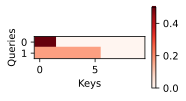

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**Scaled Dot-Product Attention**]

A more computationally efficient
design for the scoring function can be
simply dot product.
However,
the dot product operation
requires that both the query and the key
have the same vector length, say $d$.
Assume that
all the elements of the query and the key
are independent random variables
with zero mean and unit variance.
The dot product of
both vectors has zero mean and a variance of $d$.
To ensure that the variance of the dot product
still remains one regardless of vector length,
the *scaled dot-product attention* scoring function


$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

divides the dot product by $\sqrt{d}$.
In practice,
we often think in minibatches
for efficiency,
such as computing attention
for
$n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$.
The scaled dot-product attention
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
is


$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

In the following implementation of the scaled dot product attention, we use dropout for model regularization.


In [9]:
#@save
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None,
                window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
    num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To [**demonstrate the above `DotProductAttention` class**],
we use the same keys, values, and valid lengths from the earlier toy example
for additive attention.
For the dot product operation,
we make the feature size of queries
the same as that of keys.


In [10]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Same as in the additive attention demonstration,
since `keys` contains the same element
that cannot be differentiated by any query,
[**uniform attention weights**] are obtained.


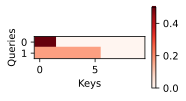

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Summary

* We can compute the output of attention pooling as a weighted average of values, where different choices of the attention scoring function lead to different behaviors of attention pooling.
* When queries and keys are vectors of different lengths, we can use the additive attention scoring function. When they are the same, the scaled dot-product attention scoring function is more computationally efficient.



## Exercises

1. Modify keys in the toy example and visualize attention weights. Do additive attention and scaled dot-product attention still output the same attention weights? Why or why not?
1. Using matrix multiplications only, can you design a new scoring function for queries and keys with different vector lengths?
1. When queries and keys have the same vector length, is vector summation a better design than dot product for the scoring function? Why or why not?


[Discussions](https://discuss.d2l.ai/t/1064)
